In [1]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt

from phase_space_reconstruction.virtual.beamlines import quadlet_tdc_bend, test_beamline
from phase_space_reconstruction.virtual.scans import run_3d_scan
from phase_space_reconstruction.diagnostics import ImageDiagnostic
from phase_space_reconstruction.visualization import plot_3d_scan_data
from phase_space_reconstruction.train import train_3d_scan

from bmadx.beam_generator import create_beam
from bmadx.plot import plot_projections
from bmadx.constants import PI

In [2]:
# lattice and data directory
p0c = 43.36e6 # reference momentum in eV/c
lattice = quadlet_tdc_bend(p0c=p0c, dipole_on=False)
data_dir = 'data'

In [3]:
# create gaussian and nongaussian beams using Bmad-X distgen functionality
gaussian_beam = create_beam(
    base_yaml = os.path.join(data_dir,'base.yaml'),
    transforms_yaml = os.path.join(data_dir,'transforms-linear.yaml'), 
    p0c = p0c,
    n_particle = 10_000
    )

nongaussian_beam = create_beam(
    base_yaml = os.path.join(data_dir,'base.yaml'),
    transforms_yaml = os.path.join(data_dir,'transforms-nonlinear.yaml'), 
    p0c = p0c,
    n_particle = 10_000
    )

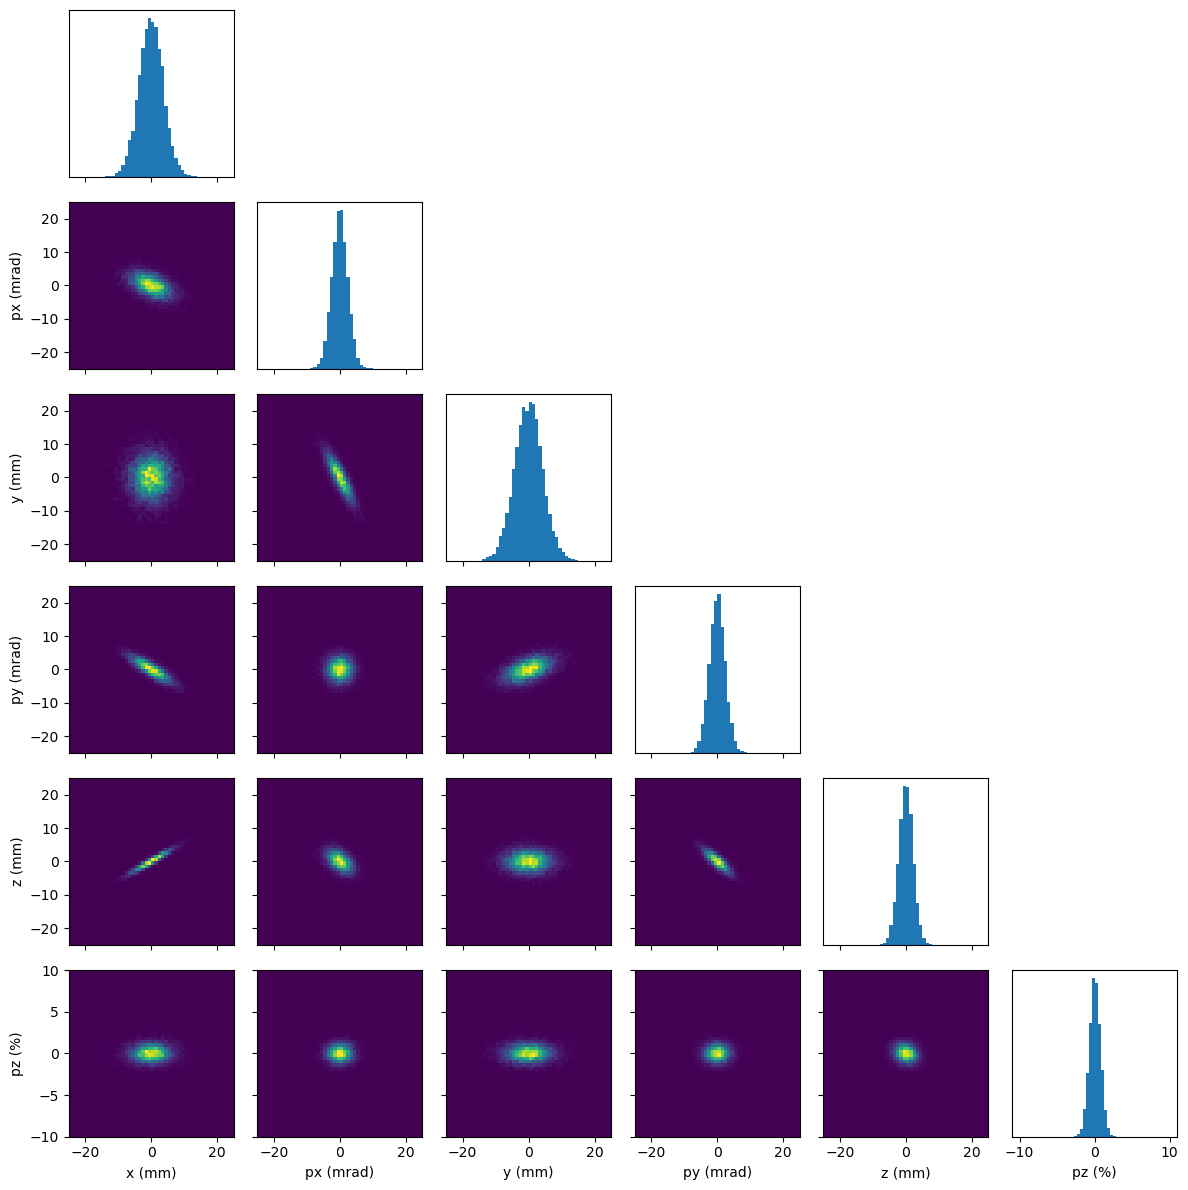

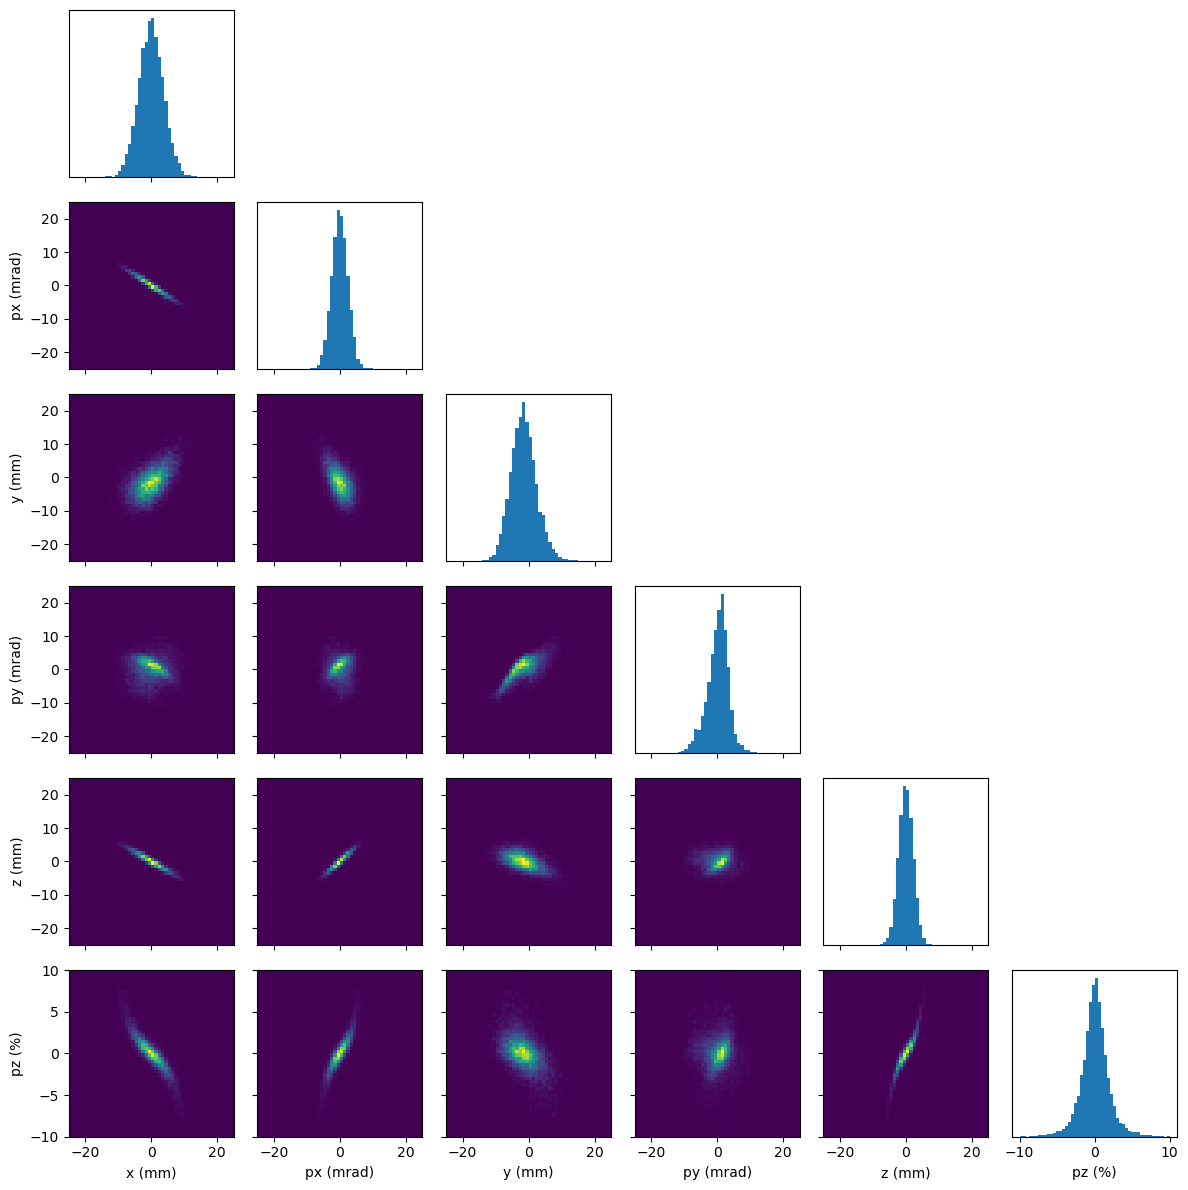

In [4]:
# plot linear and nonlinear beams
lims = np.array(
    [[-25e-3, 25e-3],
     [-25e-3, 25e-3],
     [-25e-3, 25e-3],
     [-25e-3, 25e-3],
     [-25e-3, 25e-3],
     [-10e-2, 10e-2]]
    )
fig, ax = plot_projections(gaussian_beam.numpy_particles(), custom_lims=lims)
plt.show()
fig, ax = plot_projections(nongaussian_beam.numpy_particles(), custom_lims=lims)
plt.show()

In [5]:
# use xopt for optimization
from triplet_opt import optimize_function, output
from xopt import VOCS

opt_vocs = VOCS(
        variables = {"k1":[0,20], "k2":[-20,0], "k3":[1,20]},
        objectives = {"total_size": "MINIMIZE"}
    )

opt_gaussian_beam = optimize_function(
    opt_vocs, output, n_iterations=100, 
    function_kwargs={
        'beam': gaussian_beam,
        'lattice': lattice
    }
)

opt_nongaussian_beam = optimize_function(
    opt_vocs, output, n_iterations=100, 
    function_kwargs={
        'beam': nongaussian_beam,
        'lattice': lattice
    }
)

/global/common/software/m669/jpga/conda/envs/ps-reconstruction/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# optimization results for linear beam
opt_gaussian_beam.data

,k1,k2,k3,std_x,std_y,total_size,xopt_runtime,xopt_error
1,10.476520,-6.122215,5.538713,0.010361,0.021532,0.023895,0.035889,False
2,8.121083,-7.676563,15.660497,0.011938,0.030253,0.032523,0.034069,False
3,1.427034,-15.452271,11.304300,0.005580,0.006399,0.008490,0.038116,False
4,0.000000,-19.608131,9.099928,0.010735,0.009920,0.014616,0.033442,False
5,0.000000,-13.079697,8.098108,0.007320,0.006020,0.009478,0.032789,False
...,...,...,...,...,...,...,...,...
99,7.517644,-6.319489,4.879495,0.007935,0.016512,0.018320,0.033141,False
100,11.864269,-0.357794,19.924331,0.018845,0.058442,0.061405,0.031505,False
101,12.289878,-11.228228,16.861176,0.013113,0.032503,0.035048,0.032542,False
102,11.580389,-6.871074,10.732124,0.012475,0.029869,0.032370,0.031442,False


In [7]:
opt_gaussian_beam.data.iloc[-1][["k1","k2", "k3"]]

k1     5.364958
k2        -20.0
k3    12.662418
Name: 103, dtype: object

In [8]:
# optimization results for nonlinear beam
opt_nongaussian_beam.data

,k1,k2,k3,std_x,std_y,total_size,xopt_runtime,xopt_error
1,14.389519,-2.641331,7.762490,0.017685,0.038255,0.042145,0.032388,False
2,8.942061,-18.924705,13.447675,0.007112,0.012733,0.014585,0.030865,False
3,0.509216,-7.364271,14.279204,0.008146,0.020176,0.021758,0.030751,False
4,3.169199,-18.519272,15.771194,0.004404,0.009646,0.010604,0.031811,False
5,6.185331,-19.959083,20.000000,0.008579,0.014891,0.017186,0.031420,False
...,...,...,...,...,...,...,...,...
99,1.039925,-6.279358,18.884453,0.012233,0.028002,0.030557,0.030968,False
100,17.240659,-8.912305,8.325056,0.017146,0.032263,0.036536,0.032571,False
101,1.738180,-5.032113,12.224761,0.009031,0.022875,0.024593,0.031394,False
102,9.464873,-19.876088,1.577598,0.002007,0.005401,0.005762,0.031663,False


In [9]:
opt_nongaussian_beam.data.iloc[-1][["k1","k2", "k3"]]

k1     7.570125
k2   -15.704693
k3          1.0
Name: 103, dtype: object